# Path Tracing Implicit Surfaces in JAX (Manual Vectorization)

Implementation of monte carlo path tracing using signed distance fields + raymarching, in [JAX](https://github.com/google/jax).

This version of the code (ported directly from Numpy version) does manual vectorizaton.

In [0]:
import jax.numpy as np
import jax
from jax import jit, grad, vmap, random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [0]:
RNG_KEY = random.PRNGKey(0)

In [0]:
def length(p):
  return np.linalg.norm(p, axis=1, keepdims=True)
  
def normalize(p):
  return p/length(p)

def sdSphere(p,radius):
  return length(p) - radius

def udBox(p, b):
  # b = half-widths
  return length(np.maximum(np.abs(p)-b,0.0))

def rotateX(p,a):
  c = np.cos(a); s = np.sin(a);
  px,py,pz=p[:,0,None],p[:,1,None],p[:,2,None]
  return np.concatenate([px,c*py-s*pz,s*py+c*pz],axis=1)

def rotateY(p,a):
  c = np.cos(a); s = np.sin(a);
  px,py,pz=p[:,0,None],p[:,1,None],p[:,2,None]
  return np.concatenate([c*px+s*pz,py,-s*px+c*pz],axis=1)

def rotateZ(p,a):
  c = np.cos(a); s = np.sin(a);
  px,py,pz=p[:,0,None],p[:,1,None],p[:,2,None]
  return np.concatenate([c*px-s*py,s*px+c*py,pz],axis=1)

# @jit
def opU(a,b):
  condition = np.tile(a[:,1,None]<b[:,1,None], [1, 2])
  return np.where(condition, a, b)

def clamp01(v):
  # maybe we should use sigmoid instead of hard thresholding for nicer gradients / soft shadows?
  return np.minimum(np.maximum(v,0.0),1.0)

def relu(a):
  return np.maximum(a,0.)

def dot(a,b):
  return np.sum(a*b,axis=1,keepdims=True)


In [0]:
# Discussion of cosine-weighted importance sampling for Lambertian BRDFs,
# http://www.rorydriscoll.com/2009/01/07/better-sampling/
# and implementation here:
# https://www.shadertoy.com/view/4tl3z4
# @jit
def sampleCosineWeightedHemisphere(rng_key, n):
  rng_key, subkey = random.split(rng_key)
  u1 = random.uniform(subkey,shape=(n.shape[0],1),minval=0,maxval=1)
  rng_key, subkey = random.split(rng_key)
  u2 = random.uniform(subkey, shape=(n.shape[0],1),minval=0,maxval=1)
  uu = normalize(np.cross(n, np.array([[0.,1.,1.]])))
  vv = np.cross(uu,n)
  ra = np.sqrt(u2)
  rx = ra*np.cos(2*np.pi*u1)
  ry = ra*np.sin(2*np.pi*u1)
  rz = np.sqrt(1.-u2)
  rr = rx*uu+ry*vv+rz*n
  return normalize(rr)


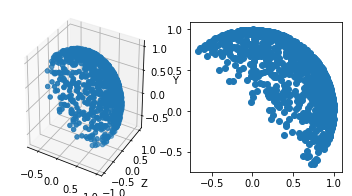

In [5]:
# testing cosine-weighted sphere projection
nor = normalize(np.array([[1.,1.,0.]]))
nor = np.tile(nor,[1000,1])
rd = sampleCosineWeightedHemisphere(RNG_KEY, nor)

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(rd[:,0],rd[:,2],rd[:,1])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_aspect('equal')

ax = fig.add_subplot(122)
ax.scatter(rd[:,0],rd[:,1])
ax.set_aspect('equal')

In [0]:
# object ids

OBJ_NONE=0.0

OBJ_FLOOR=0.1
OBJ_CEIL=.2
OBJ_WALL_RD=.3
OBJ_WALL_WH=.4
OBJ_WALL_GR=.5
OBJ_SHORT_BLOCK=.6
OBJ_TALL_BLOCK=.7
OBJ_LIGHT=1.0

OBJ_SPHERE=0.9

In [0]:
# # helper fn for constructing distance fields with object ids
def df(obj_id, dist):
  return np.concatenate([np.ones_like(dist) * obj_id, dist], axis=-1)

In [0]:
# @jit
def sdScene(p):
  px,py,pz=p[:,0,None],p[:,1,None],p[:,2,None]
  # floor
  obj_floor = df(OBJ_FLOOR, py) # py = distance from y=0
  res = obj_floor  
  # ceiling
  obj_ceil = df(OBJ_CEIL, 4.-py)
  res = opU(res,obj_ceil)
  # backwall
  obj_bwall = df(OBJ_WALL_WH, 4.-pz)

  res = opU(res,obj_bwall)
  
  # leftwall
  obj_lwall = df(OBJ_WALL_RD, px-(-2))
  res = opU(res,obj_lwall)
  
  # rightwall
  obj_rwall = df(OBJ_WALL_GR, 2-px)
  res = opU(res,obj_rwall)
  
  # light
  obj_light = df(OBJ_LIGHT, udBox(p - np.array([[0,3.9,2]]), np.array([[.5,.01,.5]])))
  res = opU(res,obj_light)
  
  # tall block
  bh = 1.3
  p2 = rotateY(p- np.array([[-.64,bh,2.6]]),.15*np.pi)
  d = udBox(p2, np.array([[.6,bh,.6]]))
  obj_tall_block = df(OBJ_TALL_BLOCK, d)
  res = opU(res,obj_tall_block)  
  
  # short block
  bw = .6
  p2 = rotateY(p- np.array([[.65,bw,1.7]]),-.1*np.pi)
  d = udBox(p2, np.array([[bw,bw,bw]]))
  obj_short_block = df(OBJ_SHORT_BLOCK, d)
  res = opU(res,obj_short_block)
  
  return res

In [0]:
# @jit
def calcNormal(p):
  # derivative approximation via midpoint rule
  eps = 0.001
  dx=np.array([[eps,0,0]])
  dy=np.array([[0,eps,0]])
  dz=np.array([[0,0,eps]])
  # exactract just the distance component
  nor = np.concatenate([
    sdScene(p+dx)[:,1,None] - sdScene(p-dx)[:,1,None],
    sdScene(p+dy)[:,1,None] - sdScene(p-dy)[:,1,None],
    sdScene(p+dz)[:,1,None] - sdScene(p-dz)[:,1,None],
  ],axis=1)
  return normalize(nor)

In [0]:
MAX_ITERS=50
HORIZON=20.0

# @jit
def raymarch(ro,rd):
  # returns df struct (id,t)
  t = 0.0
  for i in range(MAX_ITERS):
    res = sdScene(ro + t*rd)
    # print(res)
    t += res[:,1,None] # t is (N,1).
  # perform horizon cutoff
  obj_id = res[:, 0, None]
  none_object = np.ones_like(obj_id) * OBJ_NONE
  obj_id = np.where(t > HORIZON, none_object, obj_id)
  res = np.concatenate([obj_id, res[:, 1, None]], axis=1)
  # return final ids along with final distances.
  return df(res[:,0, None], t)

In [0]:

LIGHT_AREA=1.*1.
emissive_const = np.array([[25, 25, 25]])
emittedRadiance = emissive_const / (np.pi * LIGHT_AREA)
lightDiffuseColor = np.array([[0.2,0.2,0.2]])
leftWallColor = np.array([[.611, .0555, .062]]) * 1.5
rightWallColor = np.array([[.117, .4125, .115]]) * 1.5
whiteWallColor = np.array([[255, 239, 196]]) / 255

In [0]:
# we know what the light normals must be, so we don't need to analytically
# approximate. Anyways, if we learn the normal field, then
# this shouldn't be any extra computation.
nor_light = np.array([[0.,-1.,0.]])

In [0]:
BRDF_MAP = [
  (OBJ_NONE, 0.0),
  (OBJ_CEIL, whiteWallColor),
  (OBJ_FLOOR, whiteWallColor),
  (OBJ_LIGHT, lightDiffuseColor),
  (OBJ_SHORT_BLOCK, whiteWallColor),
  (OBJ_TALL_BLOCK, whiteWallColor),
  (OBJ_WALL_GR, rightWallColor),
  (OBJ_WALL_RD, leftWallColor),
  (OBJ_WALL_WH, whiteWallColor),
]

In [0]:
# depth is static.
from functools import partial

@partial(jit, static_argnums=(3,))
def trace(rng_key,ro,rd,depth):
  res = raymarch(ro,rd)
  
  # assign lambertian brdfs to intersections
  condlist, choicelist = [], []
  for obj_idx, obj_color in BRDF_MAP:
    condlist.append(res[:, 0, None] == obj_idx)
    choicelist.append(np.tile(obj_color, [res.shape[0], 1]))
  brdf = np.select(condlist, choicelist)

  radiance = np.zeros((ro.shape[0],3))
  # emitted radiance. This is only counted if it's an eye ray, since
  # this contribution is also added in at every bounce.
  if depth==0: # is eye ray
    is_light = res[:,0] == OBJ_LIGHT
    Li_e = relu(dot(-rd, nor_light)) * emittedRadiance
    radiance = np.where(is_light[:,None], Li_e, radiance)
  t = res[:,1,None]
  p = ro + t*rd
  nor = calcNormal(p)
  did_intersect = res[:,0] != OBJ_NONE
  rng_key, subkey = random.split(rng_key)

  # Estimate direct area contribution
  # each of the intersect points has some amount of light arriving
  # sample point on area light TODO (ejang) - fix hardcoded light position
  rng_key, subkey = random.split(rng_key)
  p_light_x = random.uniform(subkey, (p.shape[0], 1), minval=-.5, maxval=.5)
  rng_key, subkey = random.split(rng_key)
  p_light_z = random.uniform(subkey, (p.shape[0], 1), minval=2. + -.5, maxval=2. + .5)
  p_light = np.concatenate([p_light_x, np.ones_like(p_light_x)*3.9, p_light_z], axis=1)
  square_distance = np.sum(np.square(p_light-p), axis=1, keepdims=True)
  pdf_A = 1./LIGHT_AREA
  wi_light = normalize(p_light - p)
  res2 = raymarch(p + 0.001 * nor, wi_light)
  # occlusion factor
  vis = res2[:,0] == OBJ_LIGHT
  Li_direct = (brdf * 
               relu(dot(nor, wi_light)) * 
               relu(dot(nor_light,-wi_light)) * 
               emittedRadiance) / (square_distance * pdf_A)
  
  isect_and_vis = np.logical_and(did_intersect, vis)
  zeros = np.zeros_like(radiance)
  radiance += np.where(isect_and_vis[:,None], Li_direct, zeros)
  
  # indirect incoming contribution for intersected points
  # instead of RR sampling, we just trace for a fixed number of steps
  # to yield a good approximation and allow python to statically unroll.
  
  if depth < 3:
    # To allow JAX to jit this, we don't prune p to get did_intersect items.
    ro2 = p + 0.001 * nor # bump along normal.
    # ro2 = p[did_intersect,:] + 0.001 * nor[did_intersect,:] # bump along normal
    rng_key, subkey = random.split(rng_key)
    # rd2 = sampleCosineWeightedHemisphere(subkey, nor[did_intersect,:])
    rd2 = sampleCosineWeightedHemisphere(subkey, nor)

    rng_key, subkey = random.split(rng_key)
    Li_indirect = trace(subkey,ro2,rd2,depth+1)
    # doing cosweighted sampling cancels out the geom term
    radiance += np.where(did_intersect[:,None], brdf * Li_indirect, zeros)
  
  return radiance # actually, radiance

In [0]:
# render the image
# perspective camera with image plane centered at 0,0,0

N=100 # width of image plane
xs=np.linspace(0,1,N) # 10 pixels
us,vs = np.meshgrid(xs,xs) 
uv = np.vstack([us.flatten(),vs.flatten()]).T # 10x10 image grid

# normalize pixel locations to -1,1
p = np.concatenate([-1+2*uv, np.zeros((N*N,1))], axis=1)

# Render a pinhole camera.
eye = np.tile(np.array([0,2.,-3.5]),[p.shape[0],1])

look = np.array([[0,2.0,0]]) # look straight ahead
w = normalize(look - eye)

up = np.array([[0,1,0]]) # up axis of world

u = normalize(np.cross(w,up))
v = normalize(np.cross(u,w))

d=2.2 # focal distance
rd = normalize(p[:,0,None]*u + p[:,1,None]*v + d*w)


In [0]:
def render_multisample(rng_key, num_samples):
  img = trace(rng_key, eye, rd, 0)
  for i in range(2, num_samples+1):
    rng_key, _ = random.split(rng_key)
    sample = trace(rng_key, eye, rd, 0)
    if i % 10 == 0:
      print('Sample %d' % i)
    img = (img + sample)
  return np.fliplr(np.flipud(img.reshape((N,N,3))))/num_samples

In [17]:
%%time
img = trace(RNG_KEY, eye, rd, 0)
print('done')

done
CPU times: user 3min 40s, sys: 19.3 s, total: 4min
Wall time: 4min 7s


In [ ]:
%%time

NUM_SAMPLES=100
img = render_multisample(RNG_KEY, NUM_SAMPLES)
plt.imshow(img,interpolation='none',vmin = 0, vmax = 1)
plt.grid('off')
plt.show()

In [0]:
# # Execute everything on the TPU. This unfortunately runs out of memory :( 
# @jit
# def render_sample(i, a):
#   rng_key, img = a
#   rng_key, _ = random.split(rng_key)
#   sample = trace(rng_key, eye, rd, 0)
#   return (rng_key, img + sample)

# @jit
# def render_multisample(rng_key, img, num_samples):
#   _, img = jax.lax.fori_loop(0, num_samples, render_sample, (rng_key, img))
#   return np.fliplr(np.flipud(img.reshape((N,N,3))))/num_samples